# Compress_attn

In [ ]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from nsa_attention.torch_code import torch_blcok_compress, torch_cmp_attn, flex_cmp_attn
from nsa_attention.compress_attn_v1 import blcok_compress as triton_block_compress
from nsa_attention.compress_attn_v1 import compress_attn as triton_compress_attn_v1
from nsa_attention.compress_attn_v2 import compress_attn as triton_compress_attn_v2

## block_compress
- 目前这个版本weight是[kernel_size], pe是[kernel_size, v_head_dim / k_head_dim]

### 精度

In [3]:
device = 'cuda'
dtype = torch.bfloat16
# 论文中k的配置
b, h, n, d = 1, 4, 4096, 192
stride = 16
kernel_size = 32
x1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
x1.requires_grad_(True)
weight1 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
pe1 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))
x2 = deepcopy(x1)
weight2 = deepcopy(weight1)
pe2 = deepcopy(pe1)
x3 = torch.randn(b, n, h, d, device=device, dtype=torch.float32)
x3.requires_grad_(True)
weight3 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=torch.float32))
pe3 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=torch.float32))
x3.data.copy_(x1.data)
weight3.data.copy_(weight1.data)
pe3.data.copy_(pe1.data)

y1 = torch_blcok_compress(x1, weight1, pe1, stride)
y2 = triton_block_compress(x2, weight2, pe2, stride)
y3 = torch_blcok_compress(x3, weight3, pe3, stride)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
y3.backward(dy.float())
print('='*50 + ' forward output:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(y1-y3).abs().max().item()}, 平均差值: {(y1-y3).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(y2-y3).abs().max().item()}, 平均差值: {(y2-y3).abs().mean().item()}')
print('='*50 + ' backward input grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(x1.grad-x3.grad).abs().max().item()}, 平均差值: {(x1.grad-x3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(x2.grad-x3.grad).abs().max().item()}, 平均差值: {(x2.grad-x3.grad).abs().mean().item()}')
print('='*50 + ' backward weight grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(weight1.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight1.grad-weight3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(weight2.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight2.grad-weight3.grad).abs().mean().item()}')
print('='*50 + ' backward pe grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(pe1.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe1.grad-pe3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(pe2.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe2.grad-pe3.grad).abs().mean().item()}')

================================================== forward output:
torch   bf16 vs torch fp32: 最大差值: 0.004346370697021484, 平均差值: 0.0005613863468170166
triton  bf16 vs torch fp32: 最大差值: 36.57390213012695, 平均差值: 2.0626702308654785
================================================== backward input grad:
torch   bf16 vs torch fp32: 最大差值: 0.00048160552978515625, 平均差值: 3.8028629205655307e-05
triton  bf16 vs torch fp32: 最大差值: 0.09116840362548828, 平均差值: 0.01166438590735197
================================================== backward weight grad:
torch   bf16 vs torch fp32: 最大差值: 0.839111328125, 平均差值: 0.3525393009185791
triton  bf16 vs torch fp32: 最大差值: 0.839111328125, 平均差值: 0.3463590145111084
================================================== backward pe grad:
torch   bf16 vs torch fp32: 最大差值: 0.11561203002929688, 平均差值: 0.017232239246368408
triton  bf16 vs torch fp32: 最大差值: 0.11561203002929688, 平均差值: 0.017208479344844818


### forward

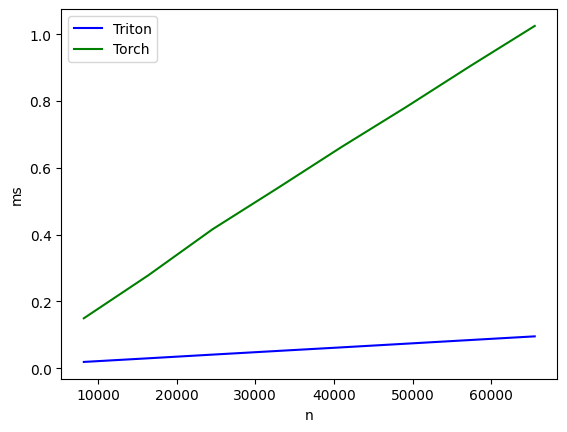

forward:
         n    Triton     Torch
0   8192.0  0.018984  0.149594
1  16384.0  0.029844  0.278162
2  24576.0  0.040907  0.416339
3  32768.0  0.051777  0.538245
4  40960.0  0.062553  0.662307
5  49152.0  0.073540  0.781580
6  57344.0  0.084555  0.904838
7  65536.0  0.095515  1.024826


In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'h':4, 'd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_blcok_compress(x, weight, pe, stride))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_block_compress(x, weight, pe, stride))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

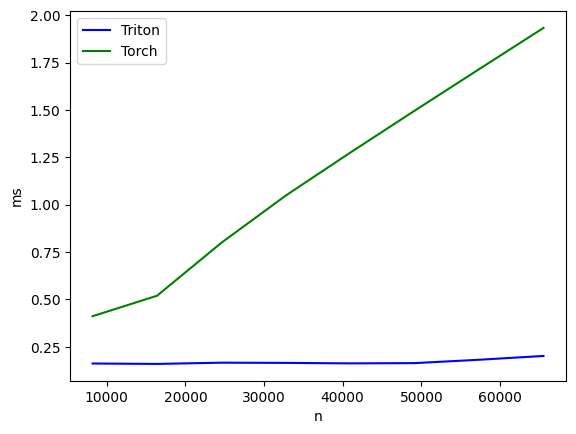

backward:
         n    Triton     Torch
0   8192.0  0.161822  0.411377
1  16384.0  0.159614  0.519400
2  24576.0  0.166136  0.799163
3  32768.0  0.165078  1.048370
4  40960.0  0.162493  1.274805
5  49152.0  0.163901  1.496214
6  57344.0  0.181611  1.715235
7  65536.0  0.201695  1.933074


In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'h':4, 'd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    x.requires_grad_(True)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch_blcok_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    if provider == 'triton':
        y = triton_block_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    return ms
benchmark.run(show_plots=True, print_data=True)

## attention

### 精度

In [6]:
n = 8192 
kernel_size = 32
stride = 16
select_size = 64
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.float16
num_blocks = (n - kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
cv1 = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
ck1.requires_grad_(True)
cv1.requires_grad_(True)
q2 = deepcopy(q1)
ck2 = deepcopy(ck1)
cv2 = deepcopy(cv1)
q3 = deepcopy(q1)
ck3 = deepcopy(ck1)
cv3 = deepcopy(cv1)

In [7]:
y1 = torch_cmp_attn(q1, ck1, cv1, kernel_size, stride)

y3, lse3 = triton_compress_attn_v1(q3, ck3, cv3, kernel_size, stride)

# dy12不是连续的，dy3要求是连续的
dy12 = torch.randn_like(y1)
dy3 = torch.rand_like(y3)
dy3.data.copy_(dy12)

y1.backward(dy12)

y3.backward(dy3)

print('='*10 + ' triton vs torch')
print((y1-y3).abs().max().item(), '\t',(y1-y3).abs().mean().item())
print((q1.grad-q3.grad).abs().max().item(), '\t',(q1.grad-q3.grad).abs().mean().item())
print((ck1.grad-ck3.grad).abs().max().item(),'\t', (ck1.grad-ck3.grad).abs().mean().item())
print((cv1.grad-cv3.grad).abs().max().item(),'\t', (cv1.grad-cv3.grad).abs().mean().item())
# 由于是GQA，kv梯度进行bf16的累加，如果是fp32或者fp16会减少误差
if math.log2(d).is_integer():
    y2 = flex_cmp_attn(q2, ck2, cv2, kernel_size, stride)
    y2.backward(dy12)
    print('='*10 + ' triton vs flex')
    print((y2-y3).abs().max().item(), '\t',(y2-y3).abs().mean().item())
    print((q2.grad-q3.grad).abs().max().item(), '\t',(q2.grad-q3.grad).abs().mean().item())
    print((ck2.grad-ck3.grad).abs().max().item(), '\t',(ck2.grad-ck3.grad).abs().mean().item()) 
    print((cv2.grad-cv3.grad).abs().max().item(), '\t',(cv2.grad-cv3.grad).abs().mean().item())

========== triton vs torch
0.00390625 	 5.793571472167969e-05
0.00390625 	 5.793571472167969e-05
0.01953125 	 0.0009298324584960938
0.0625 	 0.0009274482727050781
========== triton vs flex
0.0029296875 	 4.547834396362305e-05
0.005741119384765625 	 5.4836273193359375e-05
0.03125 	 0.0008606910705566406
0.03125 	 0.0007543563842773438


### foward

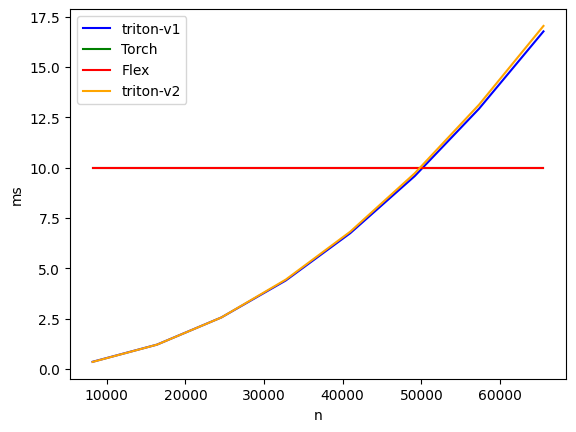

forward:
         n  triton-v1  Torch  Flex  triton-v2
0   8192.0   0.360723   10.0  10.0   0.354830
1  16384.0   1.214105   10.0  10.0   1.212156
2  24576.0   2.564557   10.0  10.0   2.563560
3  32768.0   4.400372   10.0  10.0   4.444253
4  40960.0   6.747365   10.0  10.0   6.822604
5  49152.0   9.580171   10.0  10.0   9.718672
6  57344.0  12.931236   10.0  10.0  13.131136
7  65536.0  16.770079   10.0  10.0  17.040852


In [8]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'flex', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "Torch",
            "Flex",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 10
        ms = triton.testing.do_bench(lambda: torch_cmp_attn(q, ck, cv, kernel_size, stride))
    if provider == 'triton-v1':
        ms = triton.testing.do_bench(lambda: triton_compress_attn_v1(q, ck, cv, kernel_size, stride))
    if provider == 'flex':
        if n > 4096:
            return 10
        if not math.log2(d).is_integer():
            return 10
        ms = triton.testing.do_bench(lambda: flex_cmp_attn(q, ck, cv, kernel_size, stride))
    if provider == 'triton-v2':
        ms = triton.testing.do_bench(lambda: triton_compress_attn_v2(q, ck, cv, kernel_size, stride))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

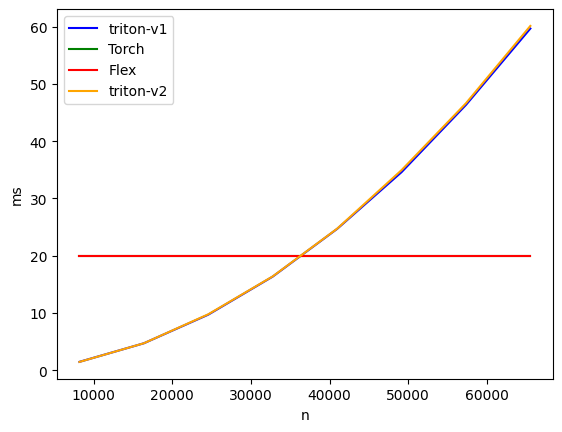

backward:
         n  triton-v1  Torch  Flex  triton-v2
0   8192.0   1.464550   20.0  20.0   1.451940
1  16384.0   4.706656   20.0  20.0   4.711893
2  24576.0   9.704409   20.0  20.0   9.769799
3  32768.0  16.347647   20.0  20.0  16.384216
4  40960.0  24.676340   20.0  20.0  24.710485
5  49152.0  34.583267   20.0  20.0  34.938370
6  57344.0  46.323631   20.0  20.0  46.611984
7  65536.0  59.664799   20.0  20.0  60.119648


In [9]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'flex', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "Torch",
            "Flex",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d,vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    ck.requires_grad_(True)
    cv.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 20
        y = torch_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'triton-v1':
        y, _ = triton_compress_attn_v1(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'triton-v2':
        y, _ = triton_compress_attn_v2(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'flex':
        if n > 4096:
            return 20
        if not math.log2(d).is_integer():
            return 10
        y = flex_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    return ms
benchmark.run(show_plots=True, print_data=True)

# Select_attn

In [ ]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from nsa_attention.torch_code import torch_select_for_fwd, torch_select_attn
from nsa_attention.select_attn_v1 import select_for_fwd_bwd as triton_select_for_fwd_bwd
from nsa_attention.select_attn_v1 import fix_bwd_ind
from nsa_attention.select_attn_v1 import select_attn as triton_select_attn_v1
from nsa_attention.select_attn_v2 import select_attn as triton_select_attn_v2
from nsa_attention.select_attn_v3 import select_attn as triton_select_attn_v3
# from exp_family import _attention, select_attn

## select

In [14]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.bfloat16
num_blocks = (n - kernel_size) // stride + 1
q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 4

In [18]:
p1, fwd_ind1 = torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
# select操作是不可导的，写前向就行了
p2, fwd_ind2, bwd_ind2 = triton_select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n, return_p=True)
p1 = p1.to(torch.float16)
print((p1 - p2).abs().max(), (p1 - p2).abs().mean())
print(((p1 - p2).abs() / (p2.abs() + 1e-3)).mean())

tensor(0.0625, device='cuda:0', dtype=torch.float16) tensor(0.0006, device='cuda:0', dtype=torch.float16)
tensor(0.0002, device='cuda:0', dtype=torch.float16)


In [20]:
print(triton.testing.do_bench(lambda: torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)))
print(triton.testing.do_bench(lambda: triton_select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n, return_p=False)))

45.70420837402344
0.29646340012550354


In [22]:
# 下面这两个不一定完全一样，p的小误差，可能选的就不一样, 大致差不多
# 128类似-100，表示不选，比如[0, 63]最多就选一个block
print(fwd_ind1[0, 0])
print(fwd_ind2[0, 0])

tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127,  68, 123,  ...,  99, 122, 115],
        [127, 117,   3,  ...,  67,  30,  22],
        [127, 119,  99,  ...,  24,  55,  16]], device='cuda:0')
tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127,  68, 123,  ...,  99, 122, 115],
        [127, 117,   3,  ...,  67,  30,  22],
        [127, 119,  99,  ...,  24,  55,  16]], device='cuda:0',
       dtype=torch.int32)


In [ ]:
# 用于attention反向传播，bwd_ind表示kv block被哪个q选了，count表示个数
# 把非0的挪到前面来，记录非0的个数，后续backward能把q在序列维度上按块读取
bwd_ind2, counts = fix_bwd_ind(bwd_ind2, inplace=False)
print(bwd_ind2[0, 0])
print(counts[0,0])

tensor([[ 255,  254,  253,  ...,    0,    0,    0],
        [ 255,  254,  253,  ...,    0,    0,    0],
        [ 255,  254,  253,  ...,    0,    0,    0],
        ...,
        [8171, 8166, 8148,  ...,    0,    0,    0],
        [8190, 8185, 8183,  ...,    0, 8191,    0],
        [8191, 8190, 8189,  ..., 8190, 8191, 8192]], device='cuda:0',
       dtype=torch.int32)
tensor([1865, 2396, 2643, 3122, 3045, 2434, 2829, 2480, 2145, 2674, 2308, 2187,
        2118, 2019, 2555, 1810, 2295, 1730, 2063, 2304, 1579, 1195, 1814, 1809,
        2108, 2069, 1704, 1582, 1437,  886, 1838, 1503,  979, 1014, 1328,  851,
        1344, 1665, 1471,  684, 1142, 1361, 1704, 1264,  833, 1282, 1035,  874,
        1318,  807, 1109,  774, 1716,  829,  690, 1112, 1911, 1155,  706,  480,
         745,  557,  707,  678,  869,  823,  753,  677,  926,  510,  689,  590,
         835,  493,  666,  520,  589,  572,  473,  384,  268,  500,  249,  569,
         687,  348,  208,  413,  160,  486,  407,  651,  298,  276,  37

## attention

### 精度测试

In [25]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.float16
num_blocks = (n-kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
k1 = torch.randn(b, n, kh, d, device=device, dtype=dtype)
v1 = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
k1.requires_grad_(True)
v1.requires_grad_(True)
q2 = deepcopy(q1)
k2 = deepcopy(k1)
v2 = deepcopy(v1)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
_, fwd_ind, bwd_ind = triton_select_for_fwd_bwd(q1, ck1, lse, kernel_size, stride, select_size, top_n)

In [26]:

y1 = torch_select_attn(q1, k1, v1, select_size, fwd_ind.to(torch.int64))
y2 = triton_select_attn_v3(q2, k2, v2, select_size, fwd_ind, bwd_ind, inplace=False)
dy1 = torch.randn_like(y1)
dy2 = torch.randn_like(y2)
dy2.data.copy_(dy1)
y1.backward(dy1)
y2.backward(dy2)
print('='*10 + ' triton vs torch')
print((y1-y2).abs().max().item(), (y1-y2).abs().mean().item())
print((q1.grad-q2.grad).abs().max().item(), (q1.grad-q2.grad).abs().mean().item())
print((k1.grad-k2.grad).abs().max().item(), (k1.grad-k2.grad).abs().mean().item())
print((v1.grad-v2.grad).abs().max().item(), (v1.grad-v2.grad).abs().mean().item())

========== triton vs torch
0.001953125 3.0338764190673828e-05
0.0029296875 3.1888484954833984e-05
0.0078125 0.0001246929168701172
0.015625 0.00011783838272094727


### forward

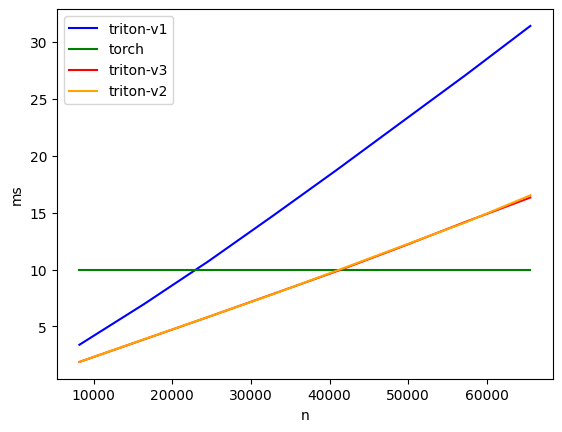

forward:
         n  triton-v1  torch  triton-v3  triton-v2
0   8192.0   3.398227   10.0   1.890808   1.892582
1  16384.0   6.957110   10.0   3.861681   3.872501
2  24576.0  10.716526   10.0   5.837596   5.843074
3  32768.0  14.701370   10.0   7.842968   7.824569
4  40960.0  18.765799   10.0   9.864832   9.912849
5  49152.0  22.930769   10.0  11.996368  12.036609
6  57344.0  27.088907   10.0  14.196389  14.149869
7  65536.0  31.378614   10.0  16.319557  16.514433


In [28]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'triton-v3', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "torch",
            "triton-v3",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 4
    _, fwd_ind, bwd_ind = triton_select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n > 4096:
            return 10
        ms = triton.testing.do_bench(lambda: torch_select_attn(q, k, v, select_size, fwd_ind))
        # ms = triton.testing.do_bench(lambda: select_attn(q, k, v, select_size, ind))
    if provider == 'triton-v1':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v1(q, k, v, select_size, fwd_ind, bwd_ind))
    if provider == 'triton-v2':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v2(q, k, v, select_size, fwd_ind, bwd_ind))
    if provider == 'triton-v3':
        # return 10
        ms = triton.testing.do_bench(lambda: triton_select_attn_v3(q, k, v, select_size, fwd_ind, bwd_ind))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

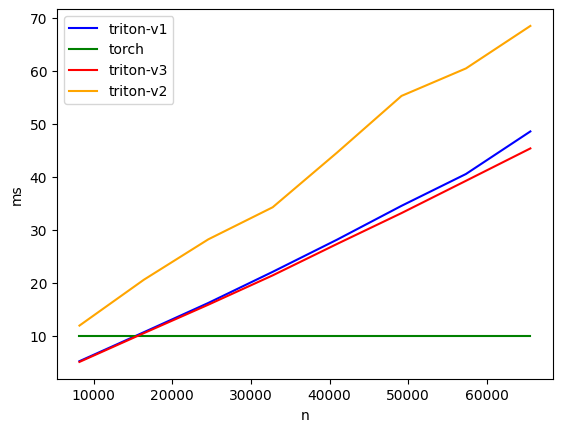

forward:
         n  triton-v1  torch  triton-v3  triton-v2
0   8192.0   5.160142   10.0   5.019858  11.884312
1  16384.0  10.634765   10.0  10.459462  20.548607
2  24576.0  16.160362   10.0  15.830400  28.180841
3  32768.0  22.043783   10.0  21.375408  34.245121
4  40960.0  28.127798   10.0  27.319319  44.586880
5  49152.0  34.516895   10.0  33.146767  55.287006
6  57344.0  40.530144   10.0  39.242607  60.479038
7  65536.0  48.574478   10.0  45.363167  68.510529


In [2]:
#bwd_ind会被原地修改,得制止下
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[8192 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-v1', 'torch', 'triton-v3', 'triton-v2'],  # possible values for `line_arg``
        line_names=[
            "triton-v1",
            "torch",
            "triton-v3",
            "triton-v2",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    k.requires_grad_(True)
    v.requires_grad_(True)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
    _, fwd_ind, bwd_ind = triton_select_for_fwd_bwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        if n>4096:
            return 10
        y = torch_select_attn(q, k, v, select_size, fwd_ind.long())
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v1':
        y = triton_select_attn_v1(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v2':
        y = triton_select_attn_v2(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton-v3':
        y = triton_select_attn_v3(q, k, v, select_size, fwd_ind, bwd_ind, inplace=False)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

# NSA_attn
- 效果还不是最好，目前知识demo

In [1]:
import torch
import triton
import triton.language as tl
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'

try:
    from flash_attn import flash_attn_func as fa2
    HAVE_FA2 = True
except:
    fa2 = None
    HAVE_FA2 = False

try:
    from flash_attn_interface import flash_attn_func as fa3
    HAVE_FA3 = True
except:
    fa3 = None
    HAVE_FA3 = False


from nsa_attention.triton_flash_attn2 import triton_fa2
from nsa_attention.nsa_attn import NsaAttention

## forward

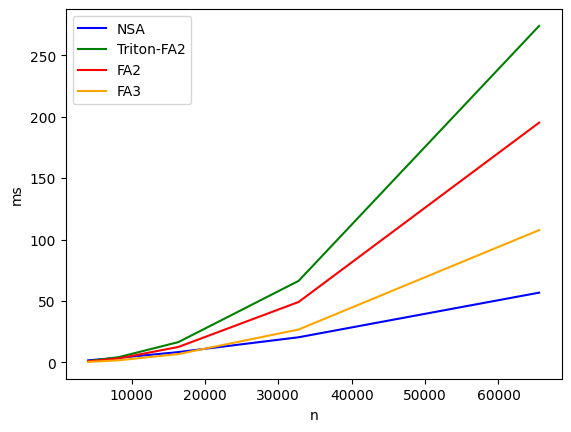

forward:
         n        NSA  Triton-FA2         FA2         FA3
0   4096.0   1.746017    1.149936    0.879112    0.454097
1   8192.0   3.766880    4.257213    3.261264    1.738003
2  16384.0   8.446412   16.563154   12.620720    6.847600
3  32768.0  20.519409   66.391747   49.222591   26.815157
4  65536.0  56.798977  273.811615  195.105530  107.702240


In [7]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'Triton-FA2', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "Triton-FA2",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16,'window_size':512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, window_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        nsa = NsaAttention(d, vd, kernel_size, stride, select_size, top_n, window_size).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: nsa(q, k, v))
    if provider == 'Triton-FA2':
        ms = triton.testing.do_bench(lambda: triton_fa2(q, k, v))
    if provider == 'FA2':
        if not HAVE_FA2:
            return 0
        ms = triton.testing.do_bench(lambda: fa2(q, k, v, causal=True))
    if provider == 'FA3':
        if not HAVE_FA3:
            return 0
        ms = triton.testing.do_bench(lambda: fa3(q, k, v, causal=True))
    return ms
benchmark.run(show_plots=True, print_data=True)

## backward

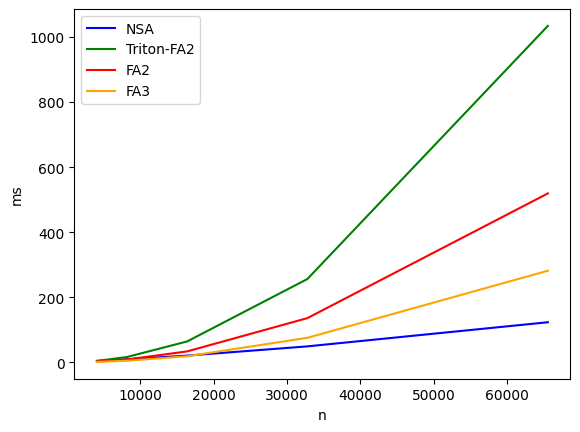

backward:
         n         NSA   Triton-FA2         FA2         FA3
0   4096.0    4.579923     4.281123    2.484126    1.388775
1   8192.0    9.463610    16.522053    8.853549    5.001499
2  16384.0   20.815048    64.331299   33.695599   18.798037
3  32768.0   49.179886   256.169586  135.992477   75.487617
4  65536.0  123.326340  1034.083984  519.226196  281.670898


In [ ]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * 2**i for i in range(0, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['NSA', 'Triton-FA2', 'FA2', 'FA3'],  # possible values for `line_arg``
        line_names=[
            "NSA",
            "Triton-FA2",
            "FA2",
            "FA3",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16,'window_size':512},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, window_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    k.requires_grad_(True)
    v.requires_grad_(True)
    dy = torch.randn(b, n, qh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'NSA':
        nsa = NsaAttention(d, vd, kernel_size, stride, select_size, top_n, window_size).to(device).to(dtype)
        # inplace用于测试，bwd_ind会被原地修改，改为不原地修改
        y = nsa(q, k, v, inplace=False)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'Triton-FA2':
        y, _ = triton_fa2(q, k, v)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'FA2':
        if not HAVE_FA2:
            return 0
        y = fa2(q, k, v, causal=True)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    if provider == 'FA3':
        if not HAVE_FA3:
            return 0
        y, _ = fa3(q, k, v, causal=True)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q,k,v])
    return ms
benchmark.run(show_plots=True, print_data=True)